In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **Data preparation**

In [51]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [52]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [53]:
gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
gender_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [54]:
decision_columns = ["Pclass", "Sex", "Age", "Cabin", "Embarked", "SibSp", "Parch", "Fare"]
label_column = "Survived"

In [55]:
decision_columns + [label_column]

['Pclass',
 'Sex',
 'Age',
 'Cabin',
 'Embarked',
 'SibSp',
 'Parch',
 'Fare',
 'Survived']

In [56]:
def preprocess_data(df):
    has_labels = df.columns[df.columns == "Survived"].shape[0] > 0
    new_columns = decision_columns + [label_column] if has_labels else decision_columns
    new_df = df.loc[:, new_columns]
    
    new_df["Age"] = new_df["Age"].fillna(new_df["Age"].median())
    new_df["Fare"] = new_df["Fare"].fillna(new_df["Fare"].median())
    new_df["LogFare"] =  np.log1p(new_df["Fare"])
    new_df["Cabin"] = new_df["Cabin"].fillna(new_df["Cabin"].mode()[0])
    new_df["Embarked"] = new_df["Embarked"].fillna(new_df["Embarked"].mode()[0])
    new_df['ShortCabin'] = new_df['Cabin'].astype(str).str[0]
    
    new_df = pd.get_dummies(new_df, columns=["Embarked", "ShortCabin", "Sex", "Pclass"])
    new_df = new_df.drop(["Cabin", "Fare"], axis=1)
    return new_df
    
prep_train_df = preprocess_data(train_df)
prep_test_df = preprocess_data(test_df)
prep_train_df

,Age,SibSp,Parch,Survived,LogFare,Embarked_C,Embarked_Q,Embarked_S,ShortCabin_A,ShortCabin_B,...,ShortCabin_D,ShortCabin_E,ShortCabin_F,ShortCabin_G,ShortCabin_T,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,0,2.110213,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
1,38.0,1,0,1,4.280593,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,26.0,0,0,1,2.188856,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
3,35.0,1,0,1,3.990834,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
4,35.0,0,0,0,2.202765,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,0,2.639057,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
887,19.0,0,0,1,3.433987,0,0,1,0,1,...,0,0,0,0,0,1,0,1,0,0
888,28.0,1,2,0,3.196630,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
889,26.0,0,0,1,3.433987,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [57]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(prep_train_df.loc[:, prep_train_df.columns != label_column], prep_train_df[label_column], test_size=0.2)

# **Random Forest**

In [58]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=3)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

In [59]:
clf.score(X_valid, y_valid)

0.8379888268156425

In [60]:
def save_predictions(test_df, prep_test_df, clf):
    test_predictions = clf.predict(prep_test_df)
    res = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": test_predictions})
    res.to_csv("submission.csv", index=False)

In [61]:
train_decision_columns = [col for col in prep_train_df.columns if col != label_column]
prep_test_df['ShortCabin_T'] = 0
prep_test_df = prep_test_df[train_decision_columns]
test_predictions = clf.predict(prep_test_df)
res = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": test_predictions})
res.to_csv("submission.csv", index=False)

In [62]:
from sklearn.decomposition import PCA

titanic_pca = PCA(n_components=7)
titanic_pca.fit(X_train)

pca_train_df = titanic_pca.transform(X_train)
pca_valid_df = titanic_pca.transform(X_valid)
pca_test_df = titanic_pca.transform(prep_test_df)

In [63]:
clf = RandomForestClassifier(max_depth=2)
clf.fit(pca_train_df, y_train)

print(clf.score(pca_valid_df, y_valid))

test_predictions = clf.predict(pca_test_df)
res = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": test_predictions})
res.to_csv("submission.csv", index=False)

0.8156424581005587


# **Gradient Boosting**

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(learning_rate=0.9, max_depth=2)
gb_clf.fit(X_train, y_train)
print(gb_clf.score(X_valid, y_valid))
save_predictions(test_df, prep_test_df, gb_clf)

0.8044692737430168


# **Neural Net**

In [65]:
!conda install pytorch torchvision -c pytorch


# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 187, in conda_http_errors
        yield
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 153, in repodata
        response.raise_for_status()
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 1021, in raise_for_status
        raise HTTPError(http_error_msg, response=self)
    requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://conda.anaconda.org/rapidsai/linux-64/current_repodata.json
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 971, in json
        return complexjson.loads(self.text, **kwargs)
      File "/opt/conda/lib/python3.10/site-packages

In [66]:
import torch

In [67]:
from torch import nn, tensor, optim

X_train_tensor, y_train_tensor = tensor(X_train.values, dtype=torch.float32), tensor(y_train.values, dtype=torch.float32)
X_valid_tensor, y_valid_tensor = tensor(X_valid.values, dtype=torch.float32), tensor(y_valid.values, dtype=torch.float32)

In [68]:
X_train_tensor.shape

torch.Size([712, 20])

In [69]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [82]:
class PredModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_fn = nn.Sequential(
            nn.Linear(20, 64), 
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(128, 96),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(96, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net_fn(x)

model = PredModel()
learning_rate = 0.003

loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

In [83]:
epochs_num = 10000

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs_num):
    model.train()
    optimizer.zero_grad()
    y_logits = model(X_train_tensor).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train_tensor)
    acc = accuracy_fn(y_train_tensor.int(), y_pred)

    loss.backward()
    optimizer.step()
    
    model.eval() 

    with torch.inference_mode():
        valid_logits = model(X_valid_tensor).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_logits))

        valid_loss = loss_fn(valid_logits, y_valid_tensor)
        valid_acc = accuracy_fn(y_valid_tensor.int(), valid_pred)    
    
    if epoch % int(epochs_num / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        valid_loss_values.append(valid_loss.detach().numpy())

Epoch:    0 | Train Loss: 0.70825, Accuracy: 41.29% | Validation Loss: 0.70874, Accuracy: 35.75%
Epoch:  500 | Train Loss: 0.66416, Accuracy: 61.66% | Validation Loss: 0.66035, Accuracy: 61.45%
Epoch: 1000 | Train Loss: 0.66394, Accuracy: 61.66% | Validation Loss: 0.65834, Accuracy: 61.45%
Epoch: 1500 | Train Loss: 0.66338, Accuracy: 61.66% | Validation Loss: 0.65650, Accuracy: 61.45%
Epoch: 2000 | Train Loss: 0.65425, Accuracy: 61.66% | Validation Loss: 0.65466, Accuracy: 61.45%
Epoch: 2500 | Train Loss: 0.65666, Accuracy: 61.66% | Validation Loss: 0.65167, Accuracy: 61.45%
Epoch: 3000 | Train Loss: 0.65506, Accuracy: 61.80% | Validation Loss: 0.64832, Accuracy: 61.45%
Epoch: 3500 | Train Loss: 0.65772, Accuracy: 61.66% | Validation Loss: 0.64475, Accuracy: 61.45%
Epoch: 4000 | Train Loss: 0.65482, Accuracy: 61.80% | Validation Loss: 0.64009, Accuracy: 61.45%
Epoch: 4500 | Train Loss: 0.65628, Accuracy: 61.52% | Validation Loss: 0.63379, Accuracy: 61.45%
Epoch: 5000 | Train Loss: 0.65

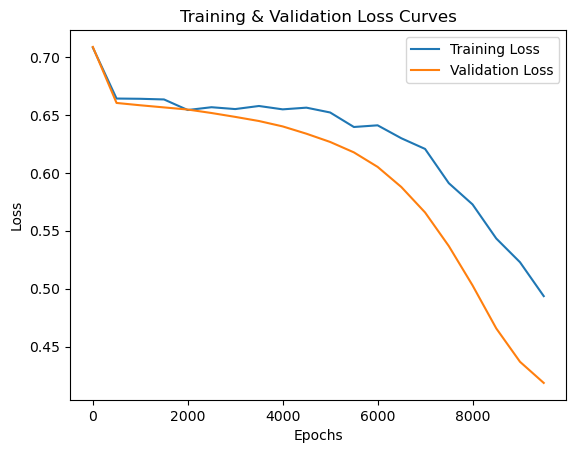

In [84]:
from matplotlib import pyplot as plt
plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [88]:
X_test_tensor = tensor(prep_test_df.values, dtype=torch.float32)

model.eval()

with torch.inference_mode():
    test_logits = model(X_test_tensor).squeeze()
    test_predictions_nn = torch.round(torch.sigmoid(test_logits)).int()
    
res = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": test_predictions_nn})
res.to_csv("submission.csv", index=False)